#### Importowanie pakietów - do poprawnego działania potrzebny jest również notatnik "projekt_funkcje.ipynb"

In [1]:
import nbimporter
import projekt_funkcje as fk

import seaborn as sns
import mne
from mypy.chans import Peakachu
%matplotlib inline

importing Jupyter notebook from projekt_funkcje.ipynb


#### Ścieżka plików - możemy zmieniać

In [2]:
directory = "/Users/Gacek/Documents/Python/Projects/Neuroscience/project-data"

#### Tworzymy listę plików "*epo.fif"

In [3]:
files = fk.load_epo_fif(directory, show_output = False)

#### Tworzymy listę epok

In [4]:
epoch_list = fk.create_epoch_list(directory = directory, files = files, show_output = False)

#### Tworzymy listę erpów

In [5]:
erp_list = fk.create_erp_list(epoch_list = epoch_list, show_output = False)

#### Uśredniamy erpy i szukamy największej aktywności

Identiying common channels ...
all channels are corresponding, nothing to do.


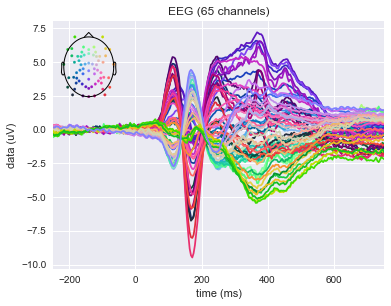

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [6]:
avg_erp = mne.grand_average(erp_list)
avg_erp.plot(spatial_colors=True);

#### Na tym etapie działa tylko N170

['E39', 'E30', 'E32', 'E43', 'E44']

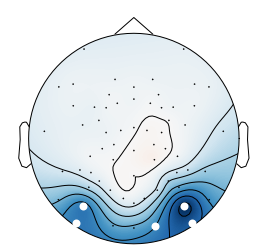

In [7]:
pika = Peakachu(mode='N170')
pika.fit(avg_erp)
fig = pika.plot_topomap();
pika._chan_names

In [8]:
conditions = ["car/0", "car/90", "car/180", "face/0", "face/90", "face/180"]

#### Tworzymy słowniki dla lats i peaks

In [9]:
lats, peaks = fk.lats_then_peaks(pika_var = pika, epoch_list = epoch_list, conditions = conditions)

#### Korzystam z RM ANOVA przy pomocy R więc potrzebuję trochę zreformatować dane

In [10]:
lats_list = []
for k in lats.keys():
    lats_list.append(lats[k])
peaks_list = []
for kk in peaks.keys():
    peaks_list.append(peaks[kk])

lats_car_0 = lats_list[0]
lats_car_90 = lats_list[1]
lats_car_180 = lats_list[2]
lats_face_0 = lats_list[3]
lats_face_90 = lats_list[4]
lats_face_180 = lats_list[5]
peaks_car_0 = peaks_list[0]
peaks_car_90 = peaks_list[1]
peaks_car_180 = peaks_list[2]
peaks_face_0 = peaks_list[3]
peaks_face_90 = peaks_list[4]
peaks_face_180 = peaks_list[5]

#### Test Levene'a jednorodności wariancji - co prawda nie jest potrzebny przy RM ANOVA, ale już zrobiłem więc szkoda usuwać.

In [11]:
fk.levene_lats_then_peaks(lats = lats, peaks = peaks)

Levene test for equal variances


,cond,p,verdict
0,lats,0.82,equal
1,peaks,0.91,equal


#### Test normalności rozkładu Shapiro-Wilka dla LATS i PEAKS

In [12]:
fk.shapiro_lats_then_peaks(lats = lats, peaks = peaks)

Shapiro-Wilk normality tests for LATS (left) and PEAKS (right)


,cond,lats p,lats verdict,cond,peaks p,peaks verdict
0,car/0,0.42,normal,car/0,0.37,normal
1,car/90,0.10,normal,car/90,0.05,not normal
2,car/180,0.46,normal,car/180,0.10,normal
3,face/0,0.80,normal,face/0,0.28,normal
4,face/90,0.56,normal,face/90,0.16,normal
5,face/180,0.03,not normal,face/180,0.35,normal


#### Ładuję R i bibliotekę car

In [13]:
%load_ext rpy2.ipython
%R library(car)

array(['car', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='<U9')

#### Anova w R dla LATS i PEAKS

In [14]:
%Rpush lats_car_0 lats_car_90 lats_car_180 lats_face_0 lats_face_90 lats_face_180
%R Factor <- c('lats_car_0', 'lats_car_90', 'lats_car_180','lats_face_0', 'lats_face_90', 'lats_face_180')
%R idata <- data.frame(Factor)
%R Bind <- cbind(lats_car_0, lats_car_90, lats_car_180, lats_face_0, lats_face_90, lats_face_180)
%R model <- lm(Bind~1)
%R analysis <- Anova(model,idata=idata,idesign=~Factor,type="III")
%R anova_sum_lats = summary(analysis)
%Rpull anova_sum_lats

In [15]:
%Rpush peaks_car_0 peaks_car_90 peaks_car_180 peaks_face_0 peaks_face_90 peaks_face_180
%R Factor <- c('peaks_car_0', 'peaks_car_90', 'peaks_car_180','peaks_face_0', 'peaks_face_90', 'peaks_face_180')
%R idata <- data.frame(Factor)
%R Bind <- cbind(peaks_car_0, peaks_car_90, peaks_car_180, peaks_face_0, peaks_face_90, peaks_face_180)
%R model <- lm(Bind~1)
%R analysis <- Anova(model,idata=idata,idesign=~Factor,type="III")
%R anova_sum_peaks = summary(analysis)
%Rpull anova_sum_peaks

#### Tworzymy wyniki RM ANOVA zgodne z APA 

In [16]:
lats_title, peaks_title = fk.anova_apa_lats_then_peaks(anova_lats = anova_sum_lats, anova_peaks = anova_sum_peaks)

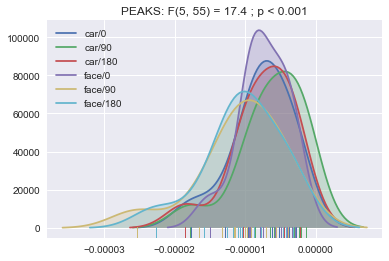

In [17]:
for cnd in conditions:
    sns.distplot(peaks[cnd], kde_kws=dict(shade=True), hist=False, rug=True, label=cnd)
    sns.plt.title(peaks_title)

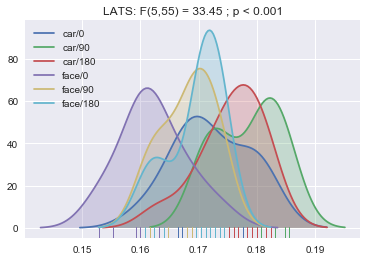

In [18]:
for cnd in conditions:
    sns.distplot(lats[cnd], kde_kws=dict(shade=True), hist=False, rug=True, label=cnd)
    sns.plt.title(lats_title)

#### Porównanie warunków testami t dla prób zależnych. Zdecydowałem się zostawić to w takiej postaci jak wcześniej. Na tym etapie udało mi się zrobić funkcję która zadziała z dowolnymi warunkami - dużo łatwiej jest z całej listy wybrać tylko to co sensowne czy potrzebne. Gdybym 

In [19]:
fk.peaks_ph(peaks_dict = peaks, conditions = conditions)

Data Frame: Dependent t-test comparison for PEAKS.


,cond1,cond2,t,p,verdict
0,car/0,car/90,-2.87,0.02,car/0 < car/90
1,car/0,car/180,-0.78,0.45,car/0 = car/180
2,car/0,face/0,-0.68,0.51,car/0 = face/0
3,car/0,face/90,4.06,0.00,car/0 > face/90
4,car/90,car/180,3.90,0.00,car/90 > car/180
5,car/90,face/0,2.31,0.04,car/90 > face/0
6,car/90,face/90,5.68,0.00,car/90 > face/90
7,car/180,face/0,-0.14,0.89,car/180 = face/0
8,car/180,face/90,4.04,0.00,car/180 > face/90
9,face/0,face/90,3.62,0.00,face/0 > face/90


In [20]:
fk.lats_ph(lats_dict = lats, conditions = conditions)

Data Frame: Dependent t-test comparison for LATS.


,cond1,cond2,t,p,verdict
0,car/0,car/90,-4.90,0.00,car/0 < car/90
1,car/0,car/180,-3.08,0.01,car/0 < car/180
2,car/0,face/0,5.16,0.00,car/0 > face/0
3,car/0,face/90,4.04,0.00,car/0 > face/90
4,car/90,car/180,1.83,0.09,car/90 = car/180
5,car/90,face/0,8.86,0.00,car/90 > face/0
6,car/90,face/90,9.05,0.00,car/90 > face/90
7,car/180,face/0,9.07,0.00,car/180 > face/0
8,car/180,face/90,8.01,0.00,car/180 > face/90
9,face/0,face/90,-4.27,0.00,face/0 < face/90
